# Load Data

In [1]:
# !pip install tqdm

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

import sys
import os
import warnings

C:\Users\Ananya\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ananya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Ananya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
    
keras = tf.keras
sns.set(style="darkgrid")

In [12]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [13]:
# Read in data
forex_data = pd.read_csv('./GBPUSD.csv')

In [14]:
df = pd.DataFrame(forex_data["Close"], columns=["Close"])
df.index = pd.to_datetime(forex_data['Date'])
df.head()

,Close
Date,
2004-01-01,1.785204
2004-01-02,1.793690
2004-01-05,1.807207
2004-01-06,1.821295
2004-01-07,1.817785


### Train Test Split

In [15]:
#Size of exchange rates
total_size = df.shape[0]
print(total_size)

#Use 80% of data as training, 10% is validation and rest 10% is Test
valid_split_index = int(total_size * 0.8)
test_split_index = int(total_size * 0.1)
x_train = df.iloc[0:valid_split_index].Close
x_valid = df.iloc[valid_split_index:-test_split_index].Close
x_test = df.iloc[-test_split_index:total_size].Close

print(x_train.index[0], x_train.index[-1])
print(x_valid.index[0], x_valid.index[-1])
print(x_test.index[0], x_test.index[-1])

4852
2004-01-01 00:00:00 2018-12-07 00:00:00
2018-12-10 00:00:00 2020-10-20 00:00:00
2020-10-21 00:00:00 2022-08-30 00:00:00


In [16]:
# creating a dataframe to store all of our model training scores to view later
model_scores_df = pd.DataFrame(columns = ["Model", "MAE", "MAPE in %"])

# Base Model - Naive Forecasting

In [17]:
naive_forecast = df[-test_split_index-1 :-1].Close

In [18]:
naive_forecast.head()

Date
2020-10-20    1.294867
2020-10-21    1.295404
2020-10-22    1.313198
2020-10-23    1.307805
2020-10-26    1.305466
Name: Close, dtype: float64

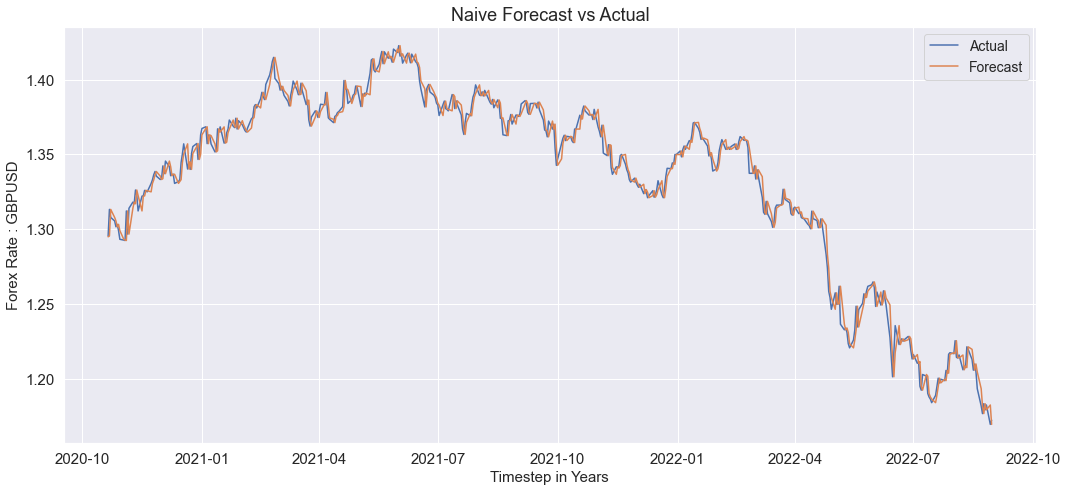

In [19]:
plt.figure(figsize=(15, 7))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Forex Rate : GBPUSD', fontsize=15)
plt.xlabel('Timestep in Years', fontsize=15)
plt.title('Naive Forecast vs Actual', fontsize=18)
plt.tight_layout()
plt.show()

### Calculate Error in Naive Model

In [20]:
# MAE
naive_forecast_mae = keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy()

# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
naive_mape = mean_absolute_percentage_error(x_test, naive_forecast) * 100

# add scores for model to dataframe
model_scores_df.loc[len(model_scores_df.index)] = ["Naive Model", naive_forecast_mae, naive_mape]

# view the dataframe of scores
model_scores_df

,Model,MAE,MAPE in %
0,Naive Model,0.00496,0.374931


# Weekly Moving Average Model (5 Day MA)

In [21]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = df['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[-test_split_index - window : - window]

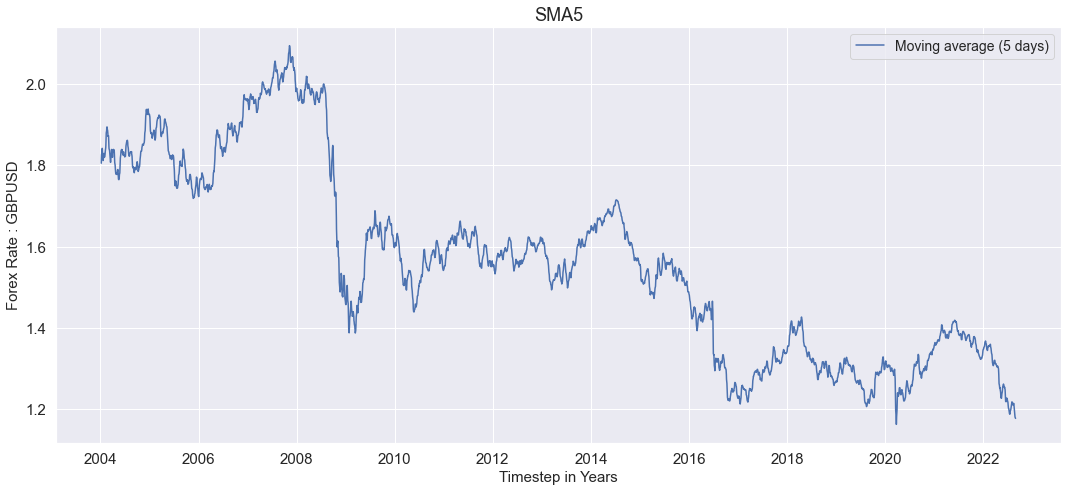

In [22]:
# plot the SMA5 values
plt.figure(figsize=(15, 7))
plot_series(df.index, moving_avg, label="Moving average (5 days)")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Forex Rate : GBPUSD', fontsize=15)
plt.xlabel('Timestep in Years', fontsize=15)
plt.title('SMA5', fontsize=18)
plt.tight_layout()
plt.show()

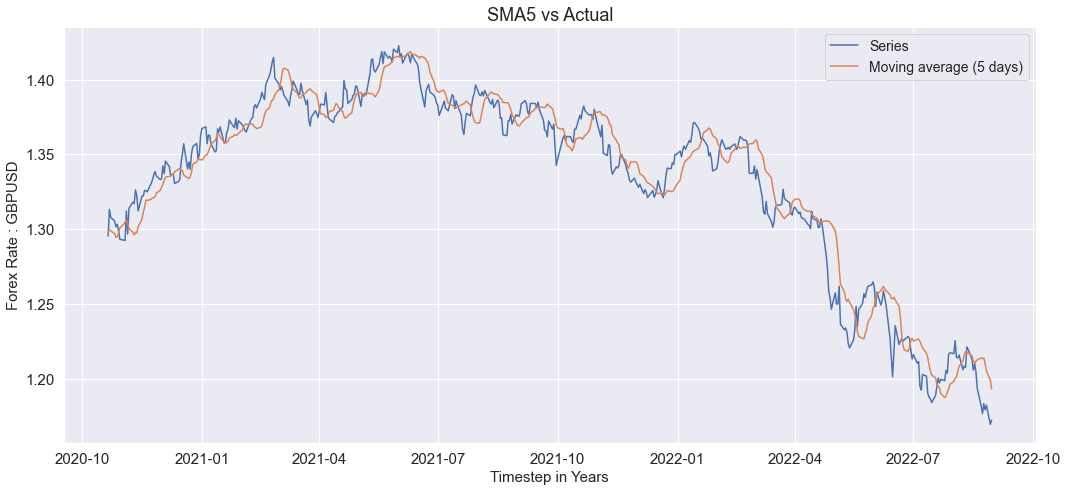

In [24]:
# plot predicted and actual values
plt.figure(figsize=(15, 7))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Forex Rate : GBPUSD', fontsize=15)
plt.xlabel('Timestep in Years', fontsize=15)
plt.title('SMA5 vs Actual', fontsize=18)
plt.tight_layout()
plt.show()

In [25]:
# MAE
ma5_mae = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

# MAPE
ma5_mape = mean_absolute_percentage_error(x_test, moving_avg_forecast) * 100

# add MA5 scores to dataframe
model_scores_df.loc[len(model_scores_df.index)] = ["MA5", ma5_mae, ma5_mape]
model_scores_df

,Model,MAE,MAPE in %
0,Naive Model,0.004960,0.374931
1,MA5,0.011755,0.893836


# Monthly Moving Average (20 day MA)

In [26]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = df['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[-test_split_index - window : - window]

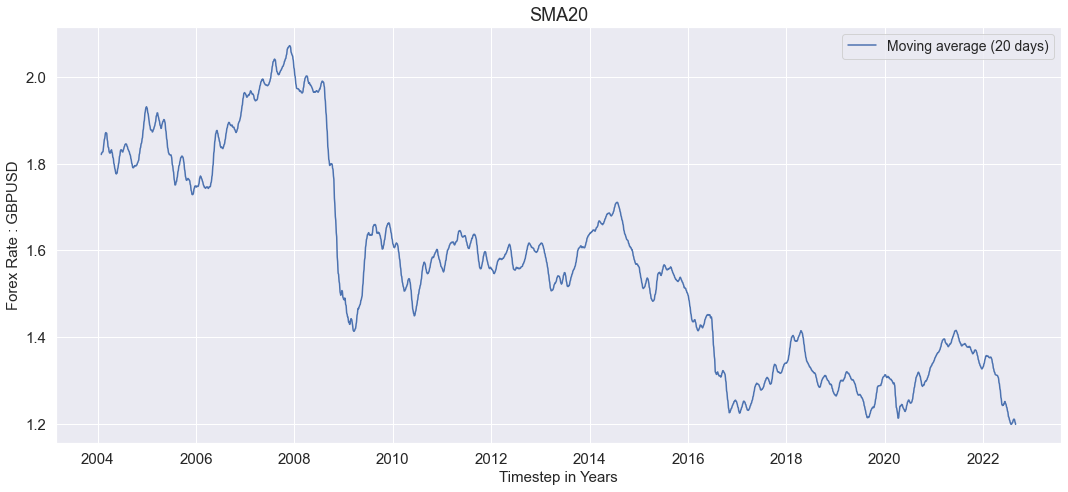

In [27]:
# plot ma20 values
plt.figure(figsize=(15, 7))
plot_series(df.index, moving_avg, label="Moving average (20 days)")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Forex Rate : GBPUSD', fontsize=15)
plt.xlabel('Timestep in Years', fontsize=15)
plt.title('SMA20', fontsize=18)
plt.tight_layout()
plt.show()

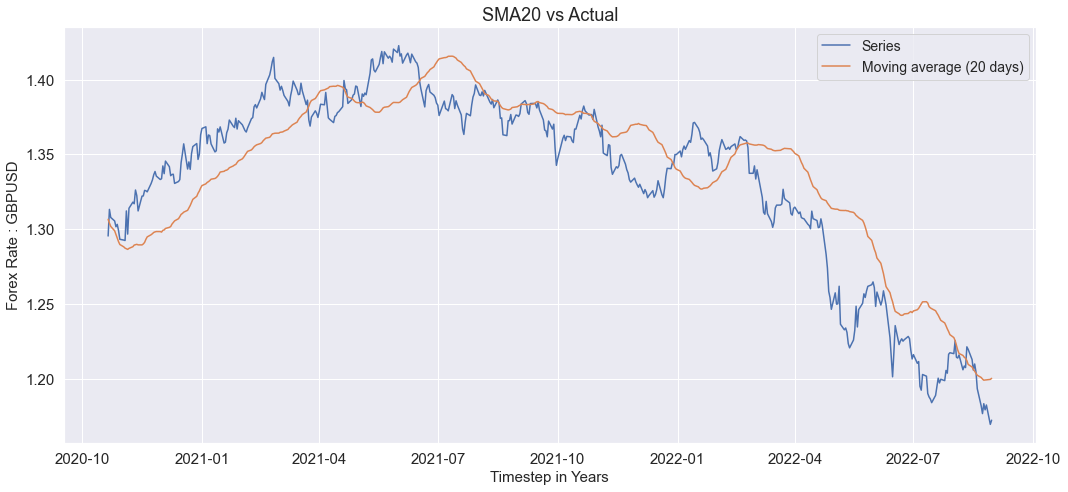

In [29]:
# plot preicted and actual values
plt.figure(figsize=(15, 7))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Forex Rate : GBPUSD', fontsize=15)
plt.xlabel('Timestep in Years', fontsize=15)
plt.title('SMA20 vs Actual', fontsize=18)
plt.tight_layout()
plt.show()

In [30]:
# MAE
ma20_mae = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

# MAPE
ma20_mape = mean_absolute_percentage_error(x_test, moving_avg_forecast) * 100

# add scores to dattaframe
model_scores_df.loc[len(model_scores_df.index)] = ["MA20", ma20_mae, ma20_mape]
model_scores_df

,Model,MAE,MAPE in %
0,Naive Model,0.004960,0.374931
1,MA5,0.011755,0.893836
2,MA20,0.024264,1.843340


# ARIMA

### Step 1: Use Augmented Dickey Fuller test to determine if the data is stationary

In [33]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, window = 5, cutoff = 0.01):

    # calculating rolling statistics - mean and standard deviation
    rolmean = series.rolling(window).mean()
    rolstd = series.rolling(window).std()

    # Plot rolling statistics and actual series to see if the series looks stationary
    # If mean and std do not vary with time, series is likely stationary
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(series, color='blue',label='Original Series')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Forex Rate", fontsize=15)
    plt.xlabel("Timestep", fontsize=15)
    plt.legend(loc='best', fontsize=15)
    plt.title('Rolling Mean & Standard Deviation', fontsize=18)
    plt.show()
    
    # Perform ADF test:
    print('Performing ADF Test:')
    adftest = adfuller(series, autolag='AIC', maxlag = 20 )
    adfoutput = pd.Series(adftest[0:2], index=['Test Statistic','p-value'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    pvalue = adftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(adfoutput)

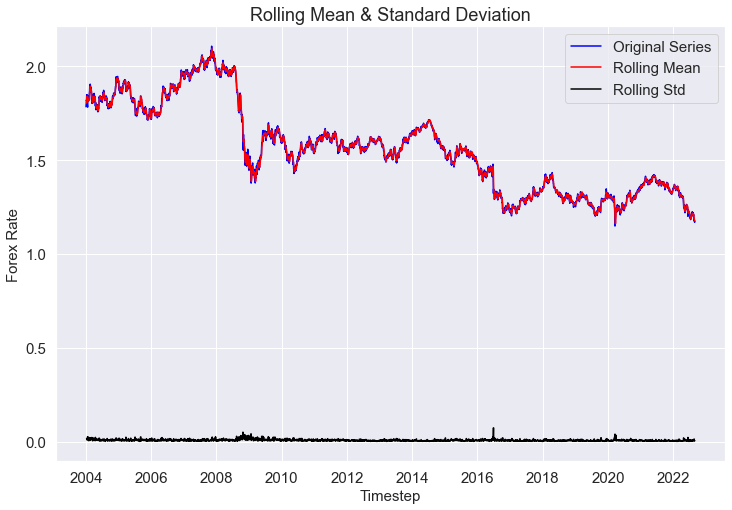

Performing ADF Test:
p-value = 0.7374. The series is likely non-stationary.
Test Statistic         -1.042638
p-value                 0.737397
Critical Value (1%)    -3.431699
Critical Value (5%)    -2.862136
Critical Value (10%)   -2.567087
dtype: float64


In [34]:
test_stationarity(df.Close)

### Step 2: Differencing to make series stationary

In [35]:
# Get the difference of each Adj Close point
forex_close_diff_1 = df.diff(1)
forex_close_diff_1.dropna(inplace=True)

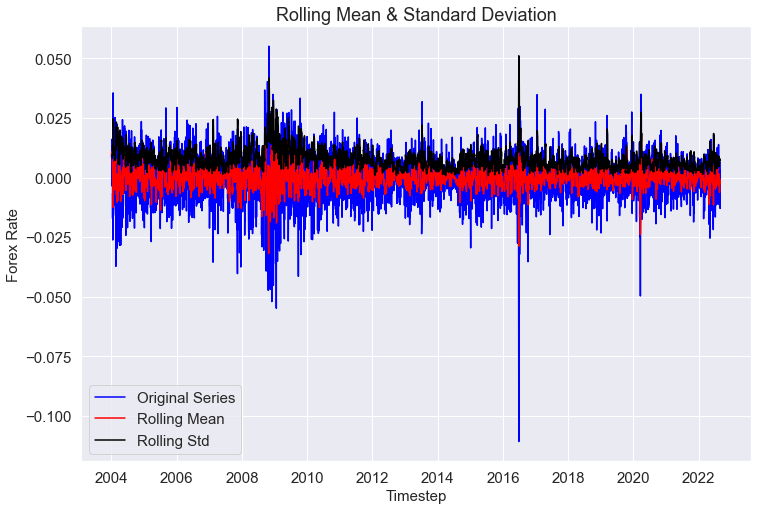

Performing ADF Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic         -68.605553
p-value                  0.000000
Critical Value (1%)     -3.431699
Critical Value (5%)     -2.862136
Critical Value (10%)    -2.567087
dtype: float64


In [36]:
# Plot the forex Adj Close 1st order difference
test_stationarity(forex_close_diff_1)

### Step 3: Find p,d,q parameters using ACF and PACF plots

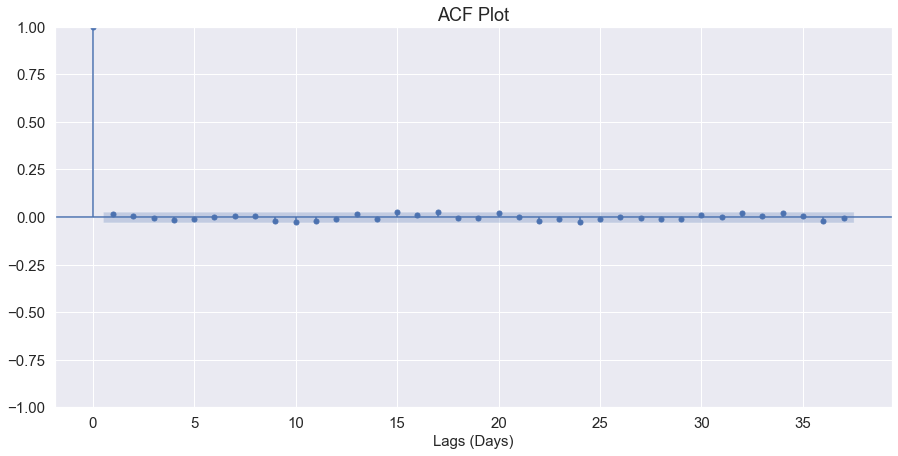

In [37]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.rc("figure", figsize=(15,7))
plot_acf(forex_close_diff_1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Lags (Days)', fontsize=15)
plt.title("ACF Plot", fontsize=18)
plt.show()

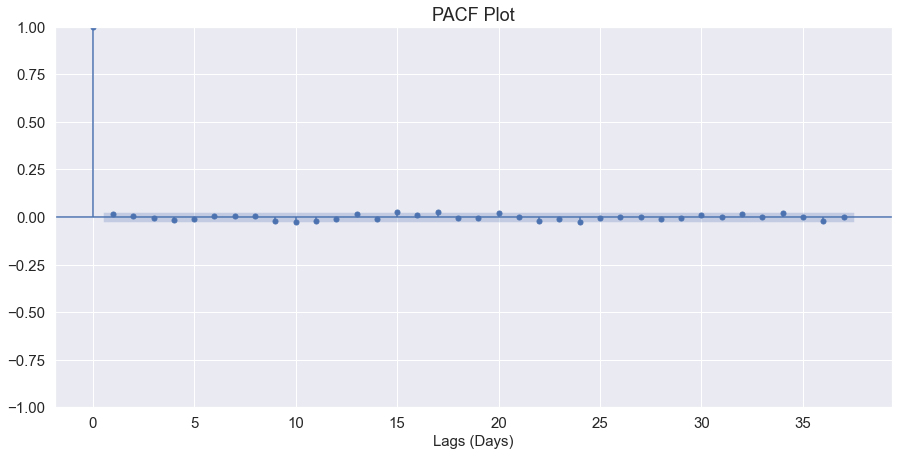

In [38]:
plt.rc("figure", figsize=(15,7))
plot_pacf(forex_close_diff_1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Lags (Days)', fontsize=15)
plt.title("PACF Plot", fontsize=18)
plt.show()

#### Step 4: using grid search to find ARIMA parameters

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

# possible range of p,d,q to test
p = range(0, 10)
d = range(1, 4)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))
aics = []
params = []

from tqdm.notebook import tqdm, trange

for param in tqdm(pdq, desc="Progress"):
    model = ARIMA(x_train, order=param)
    model.initialize_approximate_diffuse() 
    model_fit = model.fit()
    aic = model_fit.aic
    aics.append(aic)
    params.append(param)
    
# store all parameter combos and their AIC score, to help compare them and select the best    
combo = list(zip(aics, params))
combo.sort()
combo_df = pd.DataFrame(combo, columns=["AIC score", "Paramaters selected (p,d,q)"])

In [28]:
combo_df

,AIC score,"Paramaters selected (p,d,q)"
0,-24998.631630,"(0, 1, 0)"
1,-24984.464320,"(1, 1, 0)"
2,-24979.421247,"(0, 2, 1)"
3,-24974.772832,"(0, 1, 1)"
4,-24973.010832,"(2, 1, 0)"
...,...,...
295,-22241.357220,"(6, 2, 5)"
296,-22052.202836,"(3, 3, 0)"
297,-21426.941956,"(2, 3, 0)"
298,-20334.395122,"(1, 3, 0)"


### Step 5: Testing different arima models

In [66]:
from statsmodels.tsa.arima.model import ARIMA

# fit model using optimal parameters selected by grid search
forex_arima = ARIMA(x_train, order=(0,1,0))
forex_arima_fit = forex_arima.fit()
print(forex_arima_fit.summary())

###### https://stats.stackexchange.com/questions/345635/white-noise-problem-of-arima-model

C:\Users\Ananya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ananya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ananya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ananya\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3881
Model:                 ARIMA(0, 1, 0)   Log Likelihood               12503.899
Date:                Thu, 01 Sep 2022   AIC                         -25005.798
Time:                        22:34:15   BIC                         -24999.535
Sample:                             0   HQIC                        -25003.574
                               - 3881                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.295e-05   1.02e-06     90.901      0.000    9.09e-05     9.5e-05
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):              7042.72
Prob(Q):                              0.49   Pr

#### Step 6: plot the residual errors from ARIMA model created, to see if it is correct

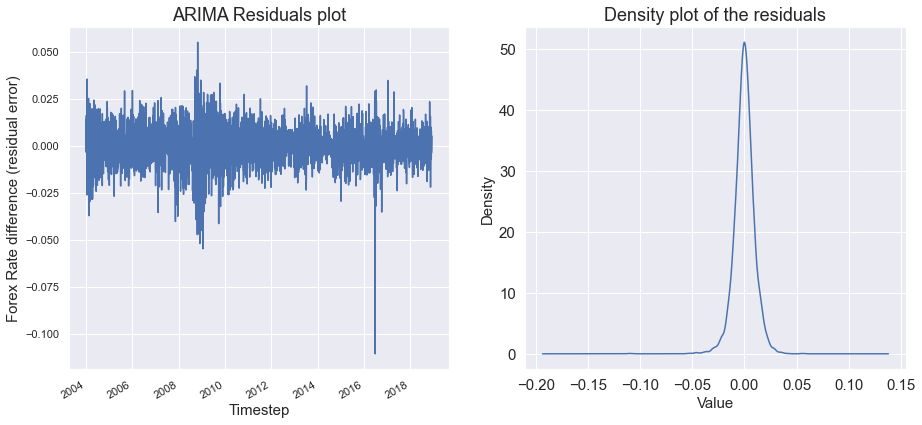

In [76]:
# plotting the residuals
residuals = forex_arima_fit.resid[1:]
fig, ax = plt.subplots(1,2)
plt.rc("figure", figsize=(15,7))
residuals.plot(title = "ARIMA Residuals plot", ax=ax[0])
ax[0].set_title("ARIMA Residuals plot", fontsize=18)
ax[0].set_xlabel("Timestep", fontsize=15)
ax[0].set_ylabel("Forex Rate difference (residual error)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

residuals.plot(title="Density plot of the residuals", kind="kde", ax=ax[1], fontsize=18)
ax[1].set_title("Density plot of the residuals", fontsize=18)
ax[1].set_xlabel("Value", fontsize=15)
ax[1].set_ylabel("Density", fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

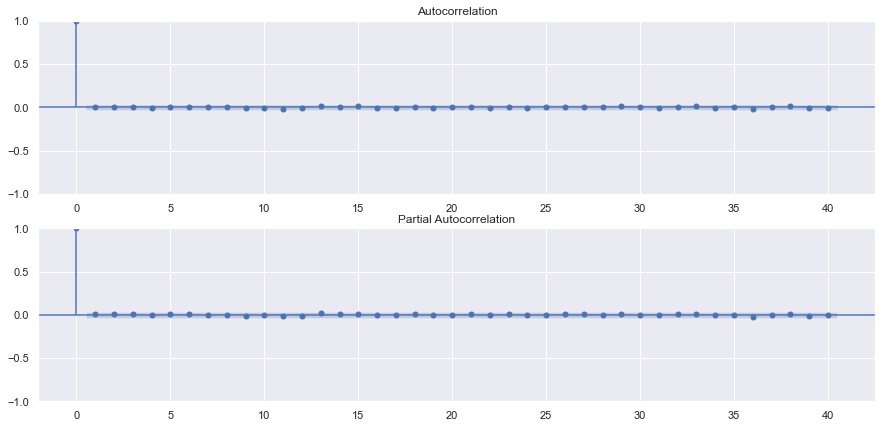

In [65]:
# ACF and PACF of the residuals
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)
plt.show()

### Step 7: Building the Arima Model and Forecasting

In [45]:
# Create list of x train and validation values
history = [x for x in x_train] + [x for x in x_valid]

# establish list for predictions
arima_model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in tqdm(list(x_test.index)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
        
MAE_error = keras.metrics.mean_absolute_error(x_test, arima_model_predictions).numpy()
print('Test Mean Squared Error is {}'.format(MAE_error))

%store arima_model_predictions

  0%|          | 0/485 [00:00<?, ?it/s]

Test Mean Squared Error is 0.004958311061269233
Stored 'arima_model_predictions' (list)


In [41]:
%store -r arima_model_predictions

In [48]:
# save model
model_fit.save('arima_010.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults

loaded = ARIMAResults.load('arima_010.pkl')

In [42]:
# arima predictions
model_predictions = np.array(arima_model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()

# Calculate MAPE
arima_mape = mean_absolute_percentage_error(x_test, model_predictions) * 100

model_scores_df.loc[len(model_scores_df.index)] = ["ARIMA (0,1,0)", arima_mae, arima_mape]
model_scores_df

,Model,MAE,MAPE in %
0,Naive Model,0.004960,0.374931
1,MA5,0.011755,0.893836
2,MA20,0.024264,1.843340
3,"ARIMA (0,1,0)",0.006906,0.522037


In [43]:
model_scores_df.to_csv("./Model scores.csv")

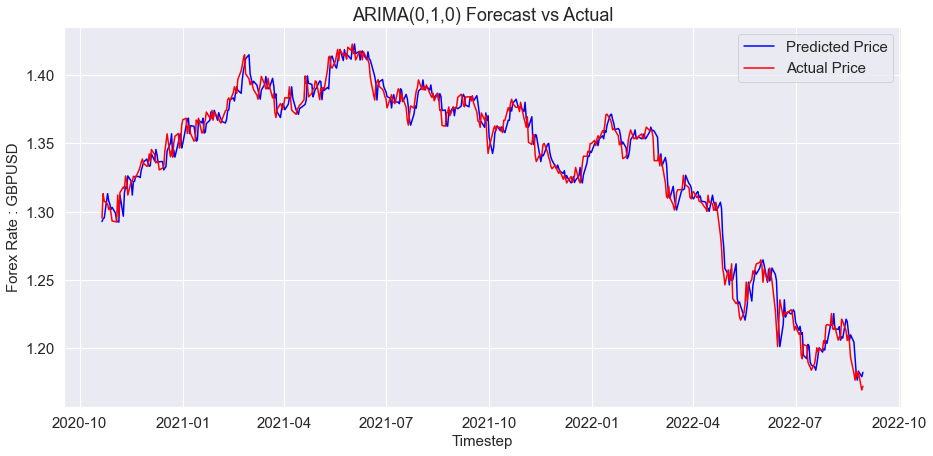

In [44]:
# Plot our predictions against the actual values for a visual comparison.
plt.figure(figsize=(15,7))
plt.plot(x_test.index, model_predictions, color='blue',label='Predicted Price')
plt.plot(x_test.index, x_test, color='red', label='Actual Price')
plt.ylabel('Forex Rate : GBPUSD', fontsize=15)
plt.xlabel('Timestep', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ARIMA(0,1,0) Forecast vs Actual', fontsize=18)
plt.legend(fontsize=15)
plt.show()

#### Show Error in predicted vs actual

In [45]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

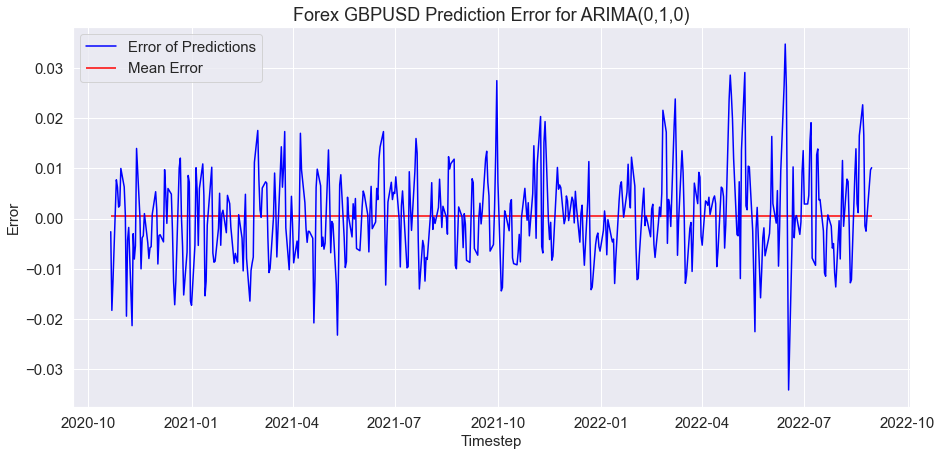

In [46]:
plt.figure(figsize=(15,7))

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
plt.title('Forex GBPUSD Prediction Error for ARIMA(0,1,0)', fontsize=18)
plt.ylabel('Error', fontsize=15)
plt.xlabel('Timestep', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()